In [1]:
import pandas as pd 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv("merge_distance_intensity.csv")

In [4]:
df.dropna(inplace=True)

df["damage_grade"] = df["damage_grade"].str.replace("Grade ", "")
df["damage_grade"] = df["damage_grade"].astype(int)
rubble = ["Damaged-Rubble unclear", "Damaged-Rubble clear", "Damaged-Rubble Clear-New building built"]
damage = ["Damaged-Used in risk", "Damaged-Repaired and used", "Damaged-Not used"]
landslide = "Covered by landslide"
nd = "Not damaged"

df["condition_post_eq"] = df["condition_post_eq"].replace(rubble, 2)
df["condition_post_eq"] = df["condition_post_eq"].replace(damage, 1)
df["condition_post_eq"] = df["condition_post_eq"].replace(landslide, 3)
df["condition_post_eq"] = df["condition_post_eq"].replace(nd, 0)

df["land_surface_condition"] = df["land_surface_condition"].replace("Flat", 0)
df["land_surface_condition"] = df["land_surface_condition"].replace("Moderate slope", 1)
df["land_surface_condition"] = df["land_surface_condition"].replace("Steep slope", 2)

df["foundation_type"] = df["foundation_type"].replace("Other",0)
df["foundation_type"] = df["foundation_type"].replace("Mud mortar-Stone/Brick",1)
df["foundation_type"] = df["foundation_type"].replace("Cement-Stone/Brick",1)
df["foundation_type"] = df["foundation_type"].replace("Bamboo/Timber",3)
df["foundation_type"] = df["foundation_type"].replace("RC",2)

df["roof_type"] = df["roof_type"].replace("RCC/RB/RBC",0)
df["roof_type"] = df["roof_type"].replace("Bamboo/Timber-Light roof",1)
df["roof_type"] = df["roof_type"].replace("Bamboo/Timber-Heavy roof",2)

df["ground_floor_type"] = df["ground_floor_type"].replace("Mud",1)
df["ground_floor_type"] = df["ground_floor_type"].replace("Brick/Stone",2)
df["ground_floor_type"] = df["ground_floor_type"].replace("RC",3)
df["ground_floor_type"] = df["ground_floor_type"].replace("Timber",4)
df["ground_floor_type"] = df["ground_floor_type"].replace("Other",0)

df["other_floor_type"] = df["other_floor_type"].replace("Not applicable",0)
df["other_floor_type"] = df["other_floor_type"].replace("TImber/Bamboo-Mud",3)
df["other_floor_type"] = df["other_floor_type"].replace("Timber-Planck",2)
df["other_floor_type"] = df["other_floor_type"].replace("RCC/RB/RBC",1)

df["position"] = df["position"].replace("Not attached",0)
df["position"] = df["position"].replace("Attached-1 side",1)
df["position"] = df["position"].replace("Attached-2 side",2)
df["position"] = df["position"].replace("Attached-3 side",3)

df = pd.get_dummies(data = df, columns = ["plan_configuration"])



In [7]:
X = df[['count_floors_pre_eq', 'age_building',
       'plinth_area_sq_ft', 'height_ft_pre_eq',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other', 'plan_configuration_Building with Central Courtyard',
       'plan_configuration_E-shape', 'plan_configuration_H-shape',
       'plan_configuration_L-shape', 'plan_configuration_Multi-projected',
       'plan_configuration_Others', 'plan_configuration_Rectangular',
       'plan_configuration_Square', 'plan_configuration_T-shape',
       'plan_configuration_U-shape', "Intensity"]]
y = df["damage_grade"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0, stratify=y)

In [25]:
import xgboost as xgb
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test)
params = {"max_depth": 15, "objective":"multi:softmax", "num_class":6, "n_gpus":0}

In [26]:
bst = xgb.train(params,dtrain)

In [27]:
pred = bst.predict(dtest)

              precision    recall  f1-score   support

           1       0.59      0.73      0.65     13537
           2       0.40      0.22      0.28     14523
           3       0.42      0.33      0.37     23075
           4       0.48      0.43      0.45     31780
           5       0.66      0.81      0.72     49342

    accuracy                           0.56    132257
   macro avg       0.51      0.50      0.50    132257
weighted avg       0.54      0.56      0.54    132257

0.5617850094891008


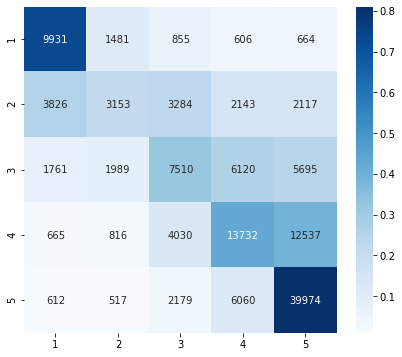

In [35]:
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred)
print(f1_score(y_test,pred,average = 'micro'))
def plot_confusion_matrix(cm, classes, normalized=True, cmap='Blues'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)
        
plot_confusion_matrix(cm, classes = [1,2,3,4,5])